In [1]:
import numpy as np
import matplotlib.pyplot as plt

import time
from tqdm import tqdm

from lightonml import OPU
import lightonml.encoding.base as base

np.random.seed(42)

In [2]:
def cpu_projector(X, m):
    n, l = X.shape
    rM = np.random.normal(size=(l, m), scale=1/(m)**0.5)
    #print(np.mean(np.diag(rM @ rM.T)))
    return X @ rM


def opu_projector(X, m):
    encoder = base.SeparatedBitPlanEncoder
    decoder = base.SeparatedBitPlanDecoder
    
    opu = OPU(n_components=m, simulated=True)
    opu.fit1d(X)
    X_p = opu.linear_transform(X, encoder, decoder)
    opu.close()
    return X_p


def rsvd(X, m, k=None, projector=cpu_projector, p=0, q=0):
    """
    Basic Randomized SVD Algorithm With Oversampling and Power Iteration

    It is factorized as ``u @ np.diag(s) @ vh = (u * s) @ vh``, where u 
    and vh are 2D unitary arrays and s is a 1D array of a's singular values.

    Parameters
    ----------
    a : array_like
        A real or complex array with ``a.ndim = 2``.
    n : int
        Target rank.
    p : int, optional
        Oversampling parameter.
    q : int, optional
        Power iteration parameter.
    """
        
    Y = projector(X, m+p)
    
    if q != 0:
        E = np.linalg.matrix_power(X @ X.T, q)
        Y = E @ Y
    
    Q, R = np.linalg.qr(Y)

    if k is not None:
        X_T = projector(X.T, k)
        Q_T = projector(Q.T, k)
        B = (X_T @ Q_T.T).T
        
    else:
        B = Q.T @ X

    _u, s, v = np.linalg.svd(B, full_matrices=False)
    u = Q @ _u

    return u, s, v


## Тесты

Сделаем тест без sketched multiplication для CPU и OPU. Ошибки почти одинаковы

In [3]:
n = 100
m = 100
X = np.random.normal(size=(n, n))
u, s, vh = rsvd(X, m)
print(np.linalg.norm(X - u @ np.diag(s) @ vh)/np.linalg.norm(X))
u, s, vh = rsvd(X, m, projector=opu_projector)
print(np.linalg.norm(X - u @ np.diag(s) @ vh)/np.linalg.norm(X))

2.6229847038711458e-15
2.435909512540504e-15


/Users/michail/opt/anaconda3/lib/python3.8/site-packages/lightonml/internal/simulated_device.py:114: UserWarning: The number of rows of random matrix (60000) are bigger than X number of features (100), consider reducing it for performance
  warnings.warn("The number of rows of random matrix ({}) are bigger than "


При m = n все работает хорошо
попробуем разные compression ratio

In [5]:
n = 10000
error = []
for alpha in np.linspace(0.01, 1, 6):
    X = np.random.normal(size=(n, n))
    u, s, vh = rsvd(X, int(n*alpha), projector=opu_projector)
    er = np.linalg.norm(X - u @ np.diag(s) @ vh)/np.linalg.norm(X)
    print(er)
    error.append(er)

/Users/michail/opt/anaconda3/lib/python3.8/site-packages/lightonml/internal/simulated_device.py:114: UserWarning: The number of rows of random matrix (60000) are bigger than X number of features (10000), consider reducing it for performance
  warnings.warn("The number of rows of random matrix ({}) are bigger than "


0.9899856248884387
0.7921136527021655
0.5940963934358023
0.39613201039417306
0.19815287980306656
8.157195063416535e-15


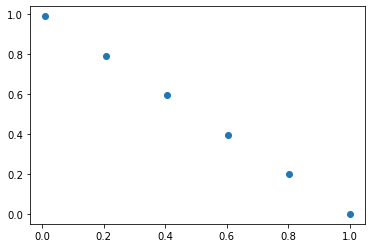

In [6]:
plt.scatter(np.linspace(0.01, 1, 6), error)

## Про нормировку рандомных матриц

У нас рандомные матрицы имеют размерность {n, m}; n>m.

При этом R @ R.T должна быть максимально близка к единичной матрицы {n, n}

Свертка идет по m - меньшему параметру. 

Тогда недиагональные члены: $\sum _{i}^{m} a_m * b_m $. Так как элементы независимы, матожидание разложиться в произведение матожиданий, каждое из которых ноль. Тогда не диагонали значения стремяться у нулю.

На диагонали: $\sum _{i} ^ {m} a_i^2$. Тут можно заметить, что дисперсия - это $D[X]=M\left[X^{2}\right]-(M[X])^{2}$. Так как $(M[X])^{2} = 0$, то на диагонали значение элементов стремится к $m* D[x]$. Тогда если взять стандартное отклонение как корень из m, то на диагоналях должна получаться 1.

### Немного мыслей про нормировку

Очевидно, что мы можем нормировать так (жертвуя производительностью):

In [7]:
def cpu_projector_norm(X, m):
    n, l = X.shape
    rM = np.random.normal(size=(l, m))
    rM = rM / (np.mean(np.diag(rM @ rM.T)))**0.5
    plt.imshow(rM @ rM.T)
    plt.colorbar()
    plt.show()
    return X @ rM

Но даже это не решает проблему большой ошибки при sketched multiplication

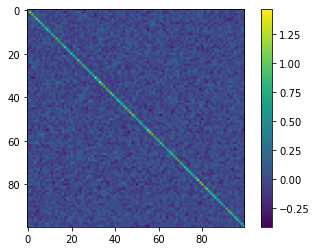

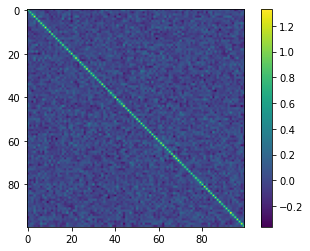

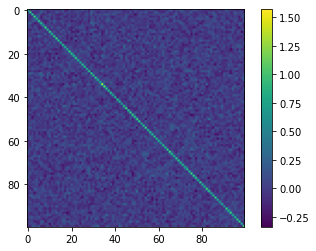

Error = 1.4067581953830992


In [8]:
n = 100
m = 100
X = np.random.normal(size=(n, n))
u, s, vh = rsvd(X, m, m, projector=cpu_projector_norm)
print("Error =", np.linalg.norm(X - u @ np.diag(s) @ vh)/np.linalg.norm(X))

Видимо важно не только подобрать нормировку, но как то избавляться от шума.

## Теперь перейдем к прямоугольным

In [15]:
n = 100
l = 1000 #так как рандомные матрицы умножаются справа, то именно эта размерность дожлжна быть больше
m = 100
X = np.random.normal(size=(n, l))
u, s, vh = rsvd(X, m)
print("CPU error = ", np.linalg.norm(X - u @ np.diag(s) @ vh)/np.linalg.norm(X))
u, s, vh = rsvd(X, m, projector=opu_projector)
print("OPU error = ", np.linalg.norm(X - u @ np.diag(s) @ vh)/np.linalg.norm(X))

CPU error =  2.5272761845024936e-15
OPU error =  2.6606396353907704e-15


In [25]:
betta = 0.1 # степень прямоугольности матрицы, betta = n/l
l = 10000
n = int(betta * l)
error = []

for alpha in np.linspace(0.01, 1, 5):
    X = np.random.normal(size=(n, l))
    u, s, vh = rsvd(X, int(l*alpha), projector=cpu_projector)
    er = np.linalg.norm(X - u @ np.diag(s) @ vh)/np.linalg.norm(X)
    print(er)
    error.append(er)

0.9439419441121389
4.064471919702078e-15
3.908739804394462e-15
4.030568764596717e-15
3.973650547695707e-15


Видно, что ошибка очень резко падает, рассмотрим подробнее.

In [26]:
betta = 0.1 # степень прямоугольности матрицы, betta = n/l
l = 10000
n = int(betta * l)
error = []

for alpha in np.linspace(0.01, 0.1, 10):
    X = np.random.normal(size=(n, l))
    u, s, vh = rsvd(X, int(l*alpha), projector=cpu_projector)
    er = np.linalg.norm(X - u @ np.diag(s) @ vh)/np.linalg.norm(X)
    print(er)
    error.append(er)

0.9439532531534315
0.8854281127434702
0.823856851947187
0.7591189854649986
0.689040755841523
0.6131136047820341
0.5281867693663516
0.4293238845462833
0.3016811328006682
4.089963401714485e-15


Text(0, 0.5, 'Error')

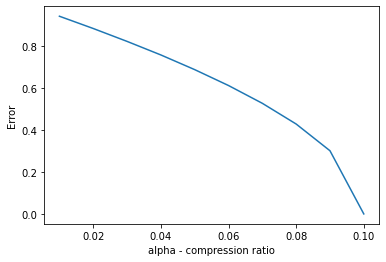

In [28]:
plt.plot(np.linspace(0.01, 0.1, 10), error)
plt.xlabel("alpha - compression ratio")
plt.ylabel("Error")

Если мы счиатем, что n << l, тогда особо нет смысла вводить sketched multiolication, так как сложность операции Q.T @ X (4-ая строчка) - mnl. Где m - размерность пространства на которое мы проектируем в самом начале (2-ая строчка).

## Немного про время работы

In [29]:
betta = 0.1 # степень прямоугольности матрицы, betta = n/l
alpha = 0.1 # compression ratio
time_ar = []
error = []
L = 50000
for l in tqdm(range(1000, L, 8000)):
    start_time = time.time()
    X = np.random.normal(size=(int(l*betta), l))
    u, s, vh = rsvd(X, int(l*alpha), projector=cpu_projector)
    time_ar.append(time.time() - start_time)
    er = np.linalg.norm(X - u @ np.diag(s) @ vh)/np.linalg.norm(X)
    error.append(er)

100%|██████████| 7/7 [06:29<00:00, 55.70s/it]


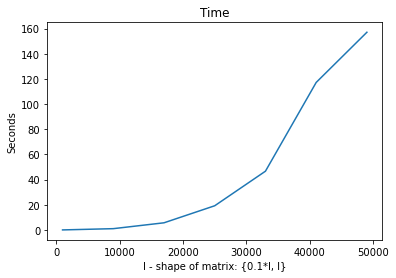

In [36]:
plt.plot(range(1000, L, 8000), time_ar)
plt.ylabel("Seconds")
plt.xlabel("l - shape of matrix: {0.1*l, l}")
plt.title("Time")
plt.show()

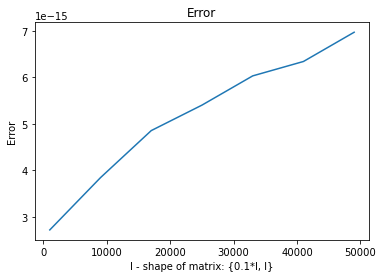

In [37]:
plt.plot(range(1000, L, 8000), error)
plt.ylabel("Error")
plt.xlabel("l - shape of matrix: {0.1*l, l}")
plt.title("Error")
plt.show()

### Сравним времена работы разных частей кода - найдем bottle neck
Не используем sketched multiplication и измеряем время на cpu. При этом параметры p = q = 0

In [3]:
betta = 0.1 # степень прямоугольности матрицы, betta = n/l
alpha = 0.1 # compression ratio
l = 80000
m = int(alpha*l)
time_ar = []
X = np.random.normal(size=(int(l*betta), l))

start_time = time.time()
Y = cpu_projector(X, m)
time_ar.append(time.time() - start_time)

start_time = time.time()
Q, R = np.linalg.qr(Y)
time_ar.append(time.time() - start_time)

start_time = time.time()
B = Q.T @ X
time_ar.append(time.time() - start_time)

start_time = time.time()
_u, s, v = np.linalg.svd(B, full_matrices=False)
time_ar.append(time.time() - start_time)

start_time = time.time()
u = Q @ _u
time_ar.append(time.time() - start_time)

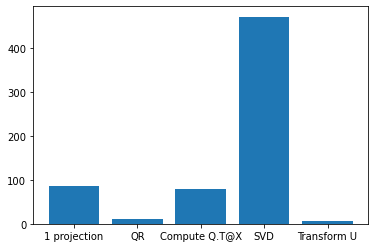

In [4]:
names = ["1 projection", "QR", "Compute Q.T@X", "SVD", "Transform U"]
plt.bar(names, time_ar)
plt.show()

SVD преобладает, что для нас плохо.

Сделаем compression rate поменьше.

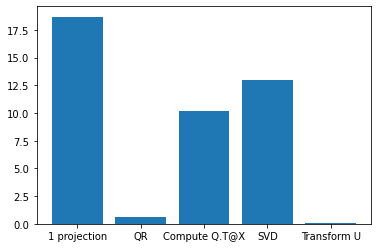

In [7]:
betta = 0.1 # степень прямоугольности матрицы, betta = n/l
alpha = 0.01 # compression ratio
l = 100000
m = int(alpha*l)
time_ar = []
X = np.random.normal(size=(int(l*betta), l))

start_time = time.time()
Y = cpu_projector(X, m)
time_ar.append(time.time() - start_time)

start_time = time.time()
Q, R = np.linalg.qr(Y)
time_ar.append(time.time() - start_time)

start_time = time.time()
B = Q.T @ X
time_ar.append(time.time() - start_time)

start_time = time.time()
_u, s, v = np.linalg.svd(B, full_matrices=False)
time_ar.append(time.time() - start_time)

start_time = time.time()
u = Q @ _u
time_ar.append(time.time() - start_time)

plt.bar(names, time_ar)
plt.show()

Тут видимо надо немного побаловаться с параметрами и понять, в каких случаях целесообразно использовать OPU, а в каких SVD занимает большую часть времени.

## Рассмотрим отдельно sketched multiplication

Нам хочется посчитать 4-ую строчку Q.T @ X с ускорением.

In [20]:
from scipy.optimize import minimize

In [11]:
def cpu_projector_norm2(X, m):
    n, l = X.shape
    rM = np.random.normal(size=(l, m))
    rM = rM / (np.mean(np.diag(rM @ rM.T)))**0.5
    plt.imshow(rM @ rM.T)
    plt.colorbar()
    plt.show()
    return X @ rM

In [27]:
def coeff(rM, X, Q, coef):
    rM = rM /coef
    X_T = X.T @ rM
    Q_T = Q.T @ rM
    B_r = (X_T @ Q_T.T).T
    B = Q.T @ X
    return np.linalg.norm(B_r - B)

betta = 1 # степень прямоугольности матрицы, betta = n/l
alpha = 0.1 # compression ratio
l = 100
m = int(alpha*l)
time_ar = []

X = np.random.normal(size=(int(l*betta), l))
Y = cpu_projector(X, m)
Q, R = np.linalg.qr(Y)

rM = np.random.normal(size=(l, m))

initial_guess = (np.mean(np.diag(rM @ rM.T)))**0.5 # initial guess 
result = minimize(lambda i: coeff(rM, X, Q, i), initial_guess)

rM = rM / result.x
    
X_T = X.T @ rM
Q_T = Q.T @ rM
B_r = (X_T @ Q_T.T).T


B = Q.T @ X

print(np.linalg.norm(B_r - B)/ np.linalg.norm(B))

0.9291186737754153


Чисто умножением на константу это не чинится.

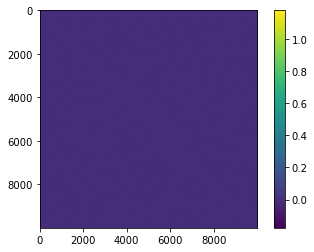

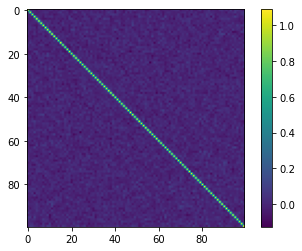

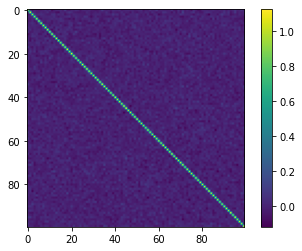

1.0432002522380472


In [45]:
betta = 0.01 # степень прямоугольности матрицы, betta = n/l
alpha = 0.1 # compression ratio
l = 10000
n = int(betta * l)

X = np.random.normal(size=(n, l))
u, s, vh = rsvd(X, int(l*alpha), int(l*alpha), projector=cpu_projector_norm)
print(np.linalg.norm(X - u @ np.diag(s) @ vh)/np.linalg.norm(X))

In [35]:
betta = 0.1 # степень прямоугольности матрицы, betta = n/l
l = 10000
n = int(betta * l)

alpha = 0.1
X = np.random.normal(size=(n, l))
u, s, vh = rsvd(X, int(l*alpha), projector=cpu_projector)
er = np.linalg.norm(X - u @ np.diag(s) @ vh)/np.linalg.norm(X)
print(er)

3.962132551067203e-15
